# Capstone Webscrapping using BeautifulSoup

This notebook contains guidances & tasks on the data processing for the application

## background

Tugas capstone kali ini adalah web scraping dengan studi kasus website lowongan kerja kalibrr.id

In [1]:
import requests

url_get = requests.get('https://www.kalibrr.id/job-board/te/data/1')

To visualize what exactly you get from the `request.get`, we can use .content so ee what we exactly get, in here i slice it so it won't make our screen full of the html we get from the page. You can delete the slicing if you want to see what we fully get.

In [2]:
url_get.content[1:500]

b'!DOCTYPE html><html lang="en"><head><meta name="viewport" content="width=device-width"/><meta charSet="utf-8"/><script type="application/ld+json">{\n    "@context": "https://schema.org",\n    "@type": "WebSite",\n    "url": "https://www.kalibrr.com",\n    "potentialAction": [\n      {\n        "@type": "SearchAction",\n        "target": "https://www.kalibrr.com/job-board/te/={search_term_string}",\n        "query-input": "required name=search_term_string"\n      }\n     ]\n  }</script><meta property="og:i'

Kita dapat menggunakan Beautifulsoup untuk mengambil tag dan mengambil text pada tag tersebut.

In [3]:
from flask import Flask, render_template, redirect, url_for
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from bs4 import BeautifulSoup 
import requests
from datetime import datetime, timedelta
import sqlite3

#don't change this
#matplotlib.use('Agg')
#app = Flask(__name__) #do not change this

soup = BeautifulSoup(url_get.content,"html.parser")

## Finding the right key to scrap the data & Extracting the right information

Berikut adalah langkah- langkah penjelasan proses scraping yang saya lakukan :

**Langkah 1:**
Pertama sekali kita mencari berapa jumlah page dari lowongan yang tersedia. tag yang kita cari adalah ```<li>``` dengan class='k-mx-2'. Ambil tag yang terakhir dengan [-1]. Simpan jumlah page ke 'last_page_number'. Nantinya kita akan melakukan loop sebanyak last_page_number.

```html
<ul class="k-flex k-justify-center k-items-center k-my-8"><li class="previous disabled"><a tabindex="0" role="button" aria-disabled="true" aria-label="Previous page" rel="prev"><svg class="MuiSvgIcon-root" focusable="false" viewBox="0 0 24 24" aria-hidden="true"><path d="M15.41 7.41L14 6l-6 6 6 6 1.41-1.41L10.83 12z"></path></svg></a></li><li class="k-mx-2 selected"><a role="button" class="k-rounded-full k-inline-flex k-items-center k-justify-center k-border-2 k-border-primary-color-200 k-w-12 k-h-12 k-font-medium k-text-grey-700 hover:k-bg-primary-color hover:k-text-white k-bg-primary-color-200 k-border-transparent k-text-primary-color k-font-bold" tabindex="0" aria-label="Page 1 is your current page" aria-current="page">1</a></li><li class="k-mx-2"><a role="button" class="k-rounded-full k-inline-flex k-items-center k-justify-center k-border-2 k-border-primary-color-200 k-w-12 k-h-12 k-font-medium k-text-grey-700 hover:k-bg-primary-color hover:k-text-white" tabindex="0" aria-label="Page 2">2</a></li><li class="k-mx-2"><a role="button" class="k-rounded-full k-inline-flex k-items-center k-justify-center k-border-2 k-border-primary-color-200 k-w-12 k-h-12 k-font-medium k-text-grey-700 hover:k-bg-primary-color hover:k-text-white" tabindex="0" aria-label="Page 3">3</a></li><li class="break"><a role="button" tabindex="0">...</a></li><li class="k-mx-2"><a role="button" class="k-rounded-full k-inline-flex k-items-center k-justify-center k-border-2 k-border-primary-color-200 k-w-12 k-h-12 k-font-medium k-text-grey-700 hover:k-bg-primary-color hover:k-text-white" tabindex="0" aria-label="Page 63">63</a></li><li class="k-mx-2"><a role="button" class="k-rounded-full k-inline-flex k-items-center k-justify-center k-border-2 k-border-primary-color-200 k-w-12 k-h-12 k-font-medium k-text-grey-700 hover:k-bg-primary-color hover:k-text-white" tabindex="0" aria-label="Page 64">64</a></li><li class="next"><a tabindex="0" role="button" aria-disabled="false" aria-label="Next page" rel="next"><svg class="MuiSvgIcon-root" focusable="false" viewBox="0 0 24 24" aria-hidden="true"><path d="M10 6L8.59 7.41 13.17 12l-4.58 4.59L10 18l6-6z"></path></svg></a></li></ul>
```

```
    last_pagination = soup.find_all('li', class_='k-mx-2')[-1]
	last_page_number = int(last_pagination.find('a').get_text())
```


**Langkah 2:**
**soup.find_all** -> mengambil beberapa content lowongan pekerjaan. dengan class="k-grid k-border- dst...
Hasilnya disimpan ke variable items dan dilakukan proses loop untuk mengambil setiap lowongan pekerjaan

```html
<div class="k-grid k-border-tertiary-ghost-color k-text-sm k-p-4 md:k-p-6 css-1b4vug6" itemscope="" itemtype="http://schema.org/ListItem" itemprop="itemListElement"><a class="k-bg-white k-flex k-items-center k-flex-shrink k-justify-center k-text-4xl k-text-subdued k-overflow-hidden k-px-4 k-py-2 k-row-span-4 keychainify-checked" href="/id-ID/c/pgi-data/jobs"><div><img loading="eager" src="https://rec-data.kalibrr.com/www.kalibrr.com/logos/Z7AL3F4XGKPLCEW9TFDFDZK33247MQ8J9PSHES26-6080167e.png" alt="PGI Data" width="130" height="80" class="k-block k-max-w-full k-max-h-full k-bg-white k-mx-auto" decoding="async"></div></a><div class="k-col-start-3 k-row-start-1"><h2 class="k-text-xl k-font-medium"><a class="k-text-primary-color keychainify-checked" itemprop="name" href="/id-ID/c/pgi-data/jobs/174503/net-developer">.Net Developer</a></h2></div><div class="k-col-start-3 k-row-start-3 k-flex k-flex-col k-justify-end"><span class="k-inline-flex k-items-center k-mb-1"><a class="k-text-subdued keychainify-checked" href="/id-ID/c/pgi-data/jobs">PGI Data</a><span class="k-ml-1 k-mb-0.5"><div class="" style="display:inline" data-tooltipped="" aria-describedby="tippy-tooltip-1" data-original-title="verified-business"></div></span></span><div class="k-flex k-flex-col md:k-flex-row"><a class="k-text-subdued k-block keychainify-checked" href="/id-ID/job-board/l/Jakarta">Jakarta, Indonesia</a></div></div><div class="k-col-start-5 k-row-start-1 k-text-right k-text-xs k-text-subdued k-hidden k-mb-2 md:k-block"><span class="k-block k-mb-1">Posted 3 days ago • Apply before 20 May</span></div></div>
```

Di setiap proses loop, ambil:
- title_pekerjaan pada tag ```<h2><a>``` sebagai nama pekerjaan
- lokasi_pekerjaan pada tag ```<div>``` ```class="k-col-start-3"``` ```<div>``` ```class="k-flex"```. Lakukan split untuk mendapatkan nama kota dan negara
- tanggal_post pada tag ```<div>``` ```class="k-col-start-5"``` ```<span>``` ```class="first-of-type"```. Lakukan split untuk mendapatkan tanggal post dan tanggal deadline
- nama perusahaan pada tag ```<div>``` ```class="k-col-start-3"``` ```<span>``` ```class="first-of-type"``` ```<a>```

**Langkah 3:**

Masih di dalam proses loop, kita melakukan beberapa data wrangling.
Kita melakukan konversi tanggal post. Contoh format tanggal post yang diambil adalah 'a day ago', '2 days ago', 'a month ago', dll. Kita melakukan perhitungan differensiasi. Setelah kita mendapat differensiasi, kurangkan dengan tanggal hari ini. Sehingga kita peroleh tanggal post lowongan tersebut dengan format datetime Y-m-d.

Kemudian melakukan konverti tanggal deadline. Ditambahkan tahun 2023, agar string yang kita peroleh dapat kita konversi ke datetime Y-m-d.

Kemudian untuk nama kota, kita melakukan proses mapping untuk menyelaraskan dengan data kota yang umum. Ada beberapa lowongan yang menggunakan bahasa inggris. Sehingga kita perlu mengubah South Jakarta menjadi Jakarta Selatan. Begitu juga dengan kota lainnya.

**Langkah 4:**
Hasil dari semuanya ini kita simpan dalam series/array
    
**Langkah 5:**
Simpan data yang discrap ke dalam table job_listing pada database kalibrr.db

**SEMUA LANGKAH DI ATAS KITA LAKUKAN DALAM SATU FUNGSI FUNC_SCRAPE() DI BAWAH INI:**

In [4]:
def func_scrape():
    con = sqlite3.connect('kalibrr.db')
    query = con.cursor()

    # Membuat tabel jika belum ada
    query.execute('''CREATE TABLE IF NOT EXISTS job_listing
             (id INTEGER PRIMARY KEY AUTOINCREMENT, title_pekerjaan TEXT, lokasi_pekerjaan TEXT, negara TEXT, tanggal_posting DATE, deadline DATE, perusahaan TEXT,
             UNIQUE(title_pekerjaan, perusahaan))''')

    #ambil jumlah page
    url_get = requests.get('https://www.kalibrr.id/job-board/te/data/1')
    soup = BeautifulSoup(url_get.content,"html.parser")
    last_pagination = soup.find_all('li', class_='k-mx-2')[-1]
    last_page_number = int(last_pagination.find('a').get_text())
    print('Total Page: '+ str(last_page_number))

    temp = [] #initiating a list
    today = datetime.today().date()

    print('Mulai Proses Scraping')
        
    for i in range(1, last_page_number):
        progress = round((i / last_page_number) * 100) # untuk menampilkan presentasi progress pada terminal
        print(f'Progress: {progress}% | Page {i} dari {last_page_number} Pages', end='\r') # untuk menampilkan jumlah page yang telah terbaca pada terminal
        
        url = 'https://www.kalibrr.id/job-board/te/data/' + str(i)
        url_get = requests.get(url)
        soup = BeautifulSoup(url_get.content,"html.parser")
        items = soup.find_all("div", {"class": "k-grid k-border-tertiary-ghost-color k-text-sm k-p-4 md:k-p-6 css-1b4vug6"})

        for item in items:
            title_pekerjaan = item.select_one("h2 a").text
            lokasi_pekerjaan = item.select_one("div.k-col-start-3 div.k-flex > a").text.strip().split(",")
            tanggal_post = item.select_one("div.k-col-start-5 span:first-of-type").text.strip().split("•")
            tanggal_posting = tanggal_post[0]
            deadline = tanggal_post[1]
            perusahaan = item.select_one("div.k-col-start-3 span:first-of-type a").text.strip()
            diff = 0
            
            # convert tanggal posting
            if 'a day ago' in tanggal_posting:
                diff = 1
            elif 'a month ago' in tanggal_posting:
                diff = 30
                
            if 'days ago' in tanggal_posting:
                diff = tanggal_posting.split(' ')[1].strip()
                
            if 'months ago' in tanggal_posting:
                diff = int(tanggal_posting.split(' ')[1].strip()) * 30
                
            tanggal_posting = today - timedelta(days=int(diff))
            # END convert tanggal posting
            
            # convert deadline
            deadline = deadline[13:].strip() + ' 2023' # default tahun 2023
            tanggal_deadline = datetime.strptime(deadline, '%d %b %Y').strftime('%Y-%m-%d')
            tanggal_deadline = datetime.strptime(tanggal_deadline, '%Y-%m-%d')
            tanggal_deadline = tanggal_deadline.date()
            # END convert deadline

            # convert nama kota
            nama_negara = lokasi_pekerjaan[1].strip()
            nama_kota = lokasi_pekerjaan[0]
            mapping = {'South Jakarta': 'Jakarta Selatan', 'West Jakarta': 'Jakarta Barat', 'North Jakarta': 'Jakarta Utara', 'East Jakarta':'Jakarta Timur', 'Jakarta':'Jakarta Pusat', 'South Tangerang': 'Tangerang Selatan', 'Bandung Kota':'Bandung', 'Bandung Kabupaten':'Bandung', 'Bogor Kota':'Bogor', 'Central Jakarta': 'Jakarta Pusat', 'Central Jakarta City': 'Jakarta Pusat', 'Central Lampung': 'Lampung', 'Kota Jakarta Barat': 'Jakarta Barat', 'Kota Jakarta Pusat':'Jakarta Pusat', 'Kota Jakarta Selatan':'Jakarta Selatan'}
            nama_kota_baru = nama_kota.replace(nama_kota, mapping.get(nama_kota, nama_kota))
            #END convert nama kota
            
            temp.append((title_pekerjaan, nama_kota_baru, nama_negara, tanggal_posting, tanggal_deadline, perusahaan))

    query.executemany('INSERT OR IGNORE INTO job_listing (title_pekerjaan, lokasi_pekerjaan, negara, tanggal_posting, deadline, perusahaan) VALUES (?, ?, ?, ?, ?, ?)', temp)
    con.commit()
    con.close()

Jalankan fungsi scrap ```func_scrape()``` untuk melakukan scraping

In [5]:
func_scrape()

Total Page: 64
Mulai Proses Scraping


Sekarang kita membuat plot. Ambil data dari database. Subsetting dari Indonesia saja. Kemudian groupby dengan value counts

<Axes: title={'center': 'Chart Lowongan Berdasarkan Kota'}, xlabel='lokasi_pekerjaan'>

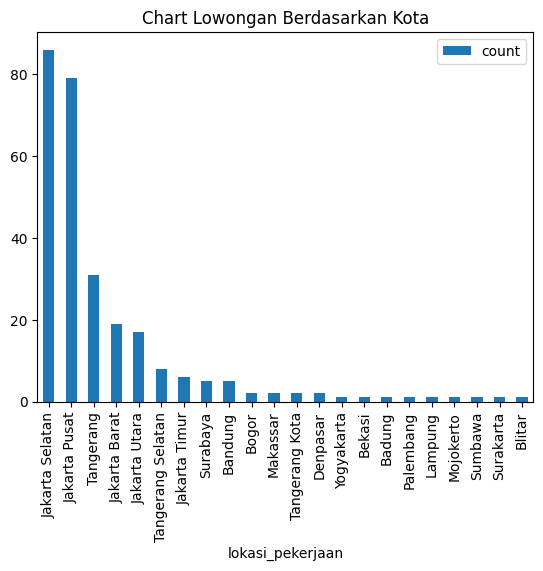

In [6]:
conn = sqlite3.connect("kalibrr.db")
data = pd.read_sql_query("SELECT * FROM job_listing", conn)  #ambil data dari database yg telah disimpan sebelumnya

# GROUP BY nama kota
data_indonesia = data[data['negara'] == 'Indonesia'] # ambil negara indonesia saja
data_grouped = pd.DataFrame(data_indonesia['lokasi_pekerjaan'].value_counts())
#data_grouped

# membuat plot
data_grouped.plot(kind='bar', title='Chart Lowongan Berdasarkan Kota')

/var/folders/p0/scssmcd51871jb80ll5vq5nc0000gn/T/ipykernel_9769/1434846659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_indonesia['tanggal_posting'] = pd.to_datetime(data_indonesia['tanggal_posting'])
/var/folders/p0/scssmcd51871jb80ll5vq5nc0000gn/T/ipykernel_9769/1434846659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_indonesia['year_month'] = data_indonesia['tanggal_posting'].dt.to_period('M')


<Axes: title={'center': 'Chart Lowongan berdasarkan Bulan'}, xlabel='year_month'>

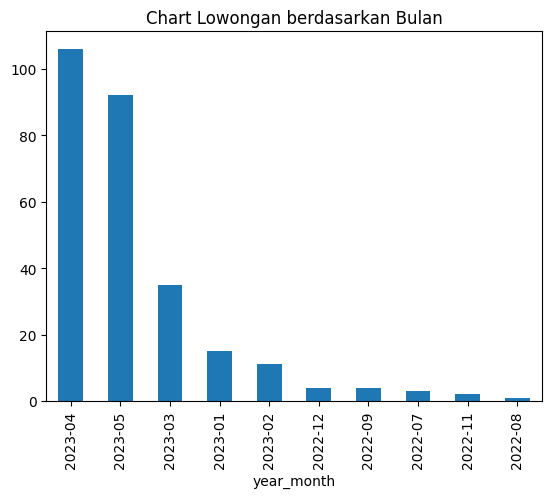

In [7]:
# GROUP BY tanggal posting (month)
data_indonesia['tanggal_posting'] = pd.to_datetime(data_indonesia['tanggal_posting'])
data_indonesia['year_month'] = data_indonesia['tanggal_posting'].dt.to_period('M')
data_grouped_month = data_indonesia['year_month'].value_counts()
#data_grouped

# membuat plot
data_grouped_month.plot(kind='bar', title='Chart Lowongan berdasarkan Bulan')

## Analisa dan Kesimpulan Plot

- Lowongan di Jakarta Selatan memiliki jumlah yang paling tinggi
- Jakarta Selatan dan Jakarta Pusat menjadi pusat lowongan pekerjaan
- Bisnis sudah mulai bergerak pindah ke Tangerang/Tangerang Selatan. Terlihat dari jumlahnya, lebih banyak daripada Jkt Barat, Jkt Timur, dan Jakarta Utara
- Bisnis di Indonesia terlalu terpusat di Jakarta dan Tangerang. Terlihat beberapa kota di luar itu, lowongan sangat sedikit
- Banyak lowongan diposting setelah lebaran